In [1]:
# dataDir = "/home/ababil/BUET/AV/csv"
dataDir = "D:/AV/Code/location-2"
# dataDir = "D:/AV/DataSetExploration/drone-dataset-tools/data/location-2"

In [2]:
exec(open('init_notebook.py').read())

current working dirD:\AV\Code\behavior-hypotheses\src


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

from tti_dataset_tools.TrajectoryTransformer import TrajectoryTransformer
from tti_dataset_tools.TrajectoryVisualizer import TrajectoryVisualizer
from tti_dataset_tools.TrajectoryCleaner import TrajectoryCleaner
from tti_dataset_tools.ColMapper import ColMapper

In [5]:
sceneId = 210
date = "2023-05-04"
fps=10
minYDisplacement = 5
maxXDisplacement = 6
pedDf = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-pedestrians.csv"))
otherDf = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-others.csv"))
tracksMeta = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-meta.csv"))

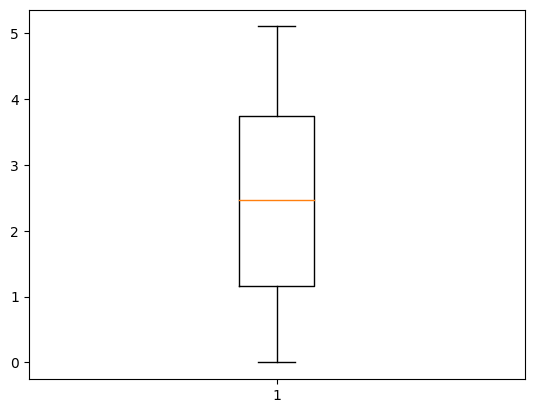

{'whiskers': [<matplotlib.lines.Line2D at 0x203f1f54880>,
 'caps': [<matplotlib.lines.Line2D at 0x203f1f54a90>,
 'boxes': [<matplotlib.lines.Line2D at 0x203f1f863d0>],
 'medians': [<matplotlib.lines.Line2D at 0x203f1f54f10>],
 'fliers': [<matplotlib.lines.Line2D at 0x203f243eee0>],
 'means': []}

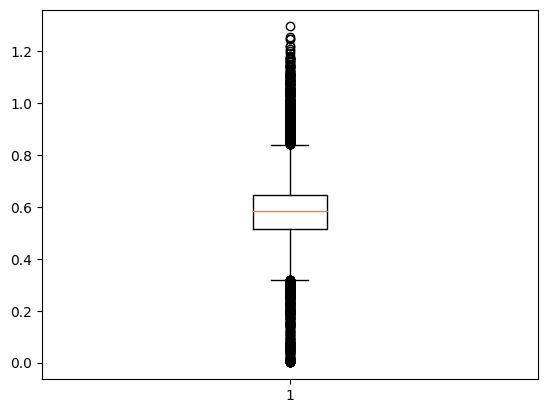

In [25]:
visualizer = TrajectoryVisualizer()
colMapper = ColMapper(
        idCol='uniqueTrackId', 
        xCol='sceneX', 
        yCol='sceneY',
        xVelCol='sceneXVelocity', 
        yVelCol='sceneYVelocity', 
        speedCol='speed',
        xAccCol='sceneXAcceleration',
        yAccCol='sceneYAcceleration',
        accelerationCol='acceleration'
        
    
    )
transformer = TrajectoryTransformer(colMapper)
cleaner = TrajectoryCleaner(
    colMapper = colMapper,
    minSpeed = 0.0, # we can consider them as obstacles
    maxSpeed = 3.5,
    minAcceleration = -10.0,
    maxAcceleration = 10.0,
    minYDisplacement = minYDisplacement,
    maxXDisplacement = maxXDisplacement
)
transformer.deriveSpeed(pedDf)
transformer.deriveDisplacements(pedDf)
transformer.deriveAcceleration(pedDf)
plt.boxplot(pedDf['displacementY'])
plt.show()
plt.boxplot(pedDf['speed'])

In [26]:
cleanPedDf = cleaner.cleanByYDisplacement(pedDf, byIQR=False)

# visualizer.show(pedDf, idCol = 'uniqueTrackId', xCol = 'sceneX', yCol = 'sceneY')
# visualizer.show(cleanPedDf, idCol = 'uniqueTrackId', xCol = 'sceneX', yCol = 'sceneY')
allPedIds = list(cleanPedDf["uniqueTrackId"].unique())
transformer.translateAllToLocalSource(cleanPedDf)

southIds = []
for pedId in allPedIds:
    trackDf = cleanPedDf[cleanPedDf["uniqueTrackId"] == pedId]
    trackMeta = tracksMeta[tracksMeta["uniqueTrackId"] == pedId].iloc[0]
    # print(trackMeta['verticalDirection'])
    if trackMeta['verticalDirection'] == "SOUTH":
        southIds.append(pedId)
        # print(trackMeta["uniqueTrackId"])
        X, Y = transformer.rotate(trackDf)
        cleanPedDf.loc[cleanPedDf["uniqueTrackId"] == pedId, 'localX'] = X
        cleanPedDf.loc[cleanPedDf["uniqueTrackId"] == pedId, 'localY'] = Y
len(cleanPedDf)


using min Y displacement (5)


7600

In [33]:

firstDf = cleanPedDf[cleanPedDf["displacementY"] < 1].copy()
secondDf = cleanPedDf[(cleanPedDf["displacementY"] >= 1) & (cleanPedDf["displacementY"] < 2)].copy()
thirdDf = cleanPedDf[(cleanPedDf["displacementY"] >= 2) & (cleanPedDf["displacementY"] < 3)].copy()
fourthDf = cleanPedDf[(cleanPedDf["displacementY"] >= 3) & (cleanPedDf["displacementY"] < 4)].copy()
fifthDf = cleanPedDf[(cleanPedDf["displacementY"] >= 4)].copy()


,recordingId,frame,uniqueTrackId,sceneId,roadWidth,sceneX,sceneY,sceneXVelocity,sceneYVelocity,sceneXAcceleration,sceneYAcceleration,speed,displacementX,displacementY,acceleration,localX,localY
0,18,750,18023,210,5.0,0.629400,2.454854,-0.047612,0.481508,-0.044860,-0.028943,0.483857,0.000000,0.000000,0.053387,-0.000000,-0.000000
1,18,752,18023,210,5.0,0.637141,2.358691,-0.038708,0.480816,-0.044520,0.003463,0.482371,0.007742,0.096163,0.044655,-0.007742,0.096163
2,18,754,18023,210,5.0,0.644921,2.261374,-0.038896,0.486585,0.000940,-0.028846,0.488137,0.015521,0.193480,0.028862,-0.015521,0.193480
3,18,756,18023,210,5.0,0.653314,2.163065,-0.041969,0.491544,0.015368,-0.024797,0.493333,0.023915,0.291789,0.029173,-0.023915,0.291789
4,18,758,18023,210,5.0,0.661952,2.065082,-0.043190,0.489915,0.006105,0.008146,0.491815,0.032553,0.389772,0.010180,-0.032553,0.389772
5,18,760,18023,210,5.0,0.670135,1.967831,-0.040911,0.486252,-0.011395,0.018314,0.487970,0.040735,0.487023,0.021570,-0.040735,0.487023
6,18,762,18023,210,5.0,0.679707,1.870670,-0.047861,0.485808,0.034750,0.002224,0.488159,0.050307,0.584184,0.034821,-0.050307,0.584184
7,18,764,18023,210,5.0,0.690215,1.773153,-0.052542,0.487584,0.023403,-0.008883,0.490407,0.060815,0.681701,0.025032,-0.060815,0.681701
8,18,766,18023,210,5.0,0.701232,1.674626,-0.055084,0.492634,0.012713,-0.025248,0.495704,0.071832,0.780228,0.028268,-0.071832,0.780228
9,18,768,18023,210,5.0,0.712428,1.575365,-0.055981,0.496305,0.004481,-0.018357,0.499452,0.083028,0.879489,0.018896,-0.083028,0.879489


In [28]:
# startingDf_copy = startingDf
# # startingDf_copy.drop(['recordingId', 'frame', 'uniqueTrackId','sceneId','roadWidth','sceneX','sceneY','sceneXVelocity','sceneYVelocity','sceneXAcceleration','sceneYAcceleration','displacementX','displacementY','localX','localY'], axis=1)
# # startingDf_copy.drop(['recordingId'], axis=1)
# startingDf_copy.pop('recordingId')
# startingDf_copy.pop('frame')
# startingDf_copy.pop('uniqueTrackId')
# startingDf_copy.pop('sceneId')
# startingDf_copy.pop('roadWidth')
# startingDf_copy.pop('sceneX')
# startingDf_copy.pop('sceneY')
# startingDf_copy.pop('sceneXVelocity')
# startingDf_copy.pop('sceneYVelocity')
# startingDf_copy.pop('sceneXAcceleration')
# startingDf_copy.pop('sceneYAcceleration')
# startingDf_copy.pop('displacementX')
# startingDf_copy.pop('displacementY')
# startingDf_copy.pop('localX')
# startingDf_copy.pop('localY')



# startingDf_copy.head(10)

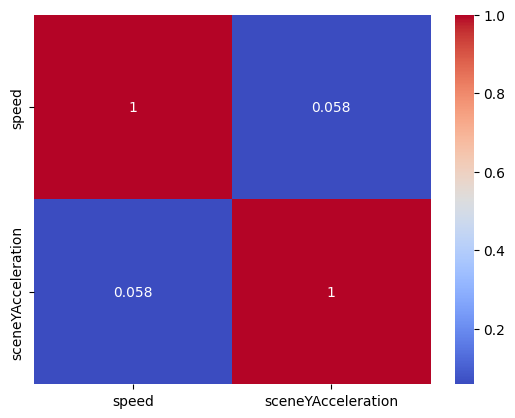

In [35]:
numeric_col = ['speed','sceneYAcceleration']

startingDf_copy = endDf
 
# Correlation Matrix formation
corr_matrix = startingDf_copy.loc[:,numeric_col].corr()
# correlation_matrix = startingDf.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

# plt.xlabel('Speed')
# plt.ylabel('Acceleration')
plt.show()


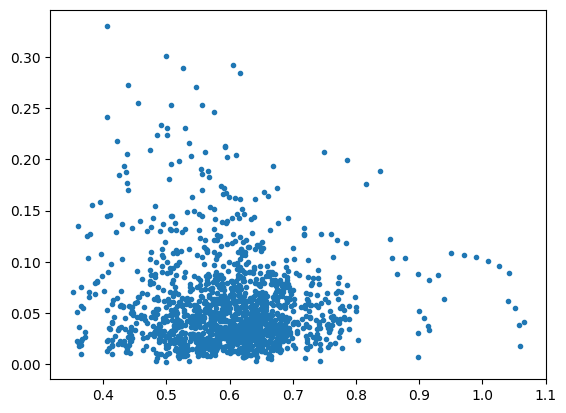

In [36]:
# numeric_col_dis = ['speed','acceleration','displacementY']
# startingDf_copy2 = startingDf
# # Correlation Matrix formation
# corr_matrix_dis = startingDf_copy2.loc[:,numeric_col_dis].corr()
# # correlation_matrix = startingDf.corr()
# sns.heatmap(corr_matrix_dis, annot=True, cmap='coolwarm')

plt.scatter(startingDf["speed"], startingDf["acceleration"], marker = ".")

# plt.xlabel('Speed')
# plt.ylabel('Acceleration')
plt.show()

In [ ]:

plt.rc('font', size=20)
plt.rc('axes', labelsize=28) #fontsize of the x and y labels
plt.scatter(midEditedDf["speed"], midEditedDf["acceleration"], marker = ".")
for pedId in allPedIds:
    uniqueTrackId_collection[pedId] = midEditedDf[midEditedDf["uniqueTrackId"] == pedId].copy()
    plt.plot(uniqueTrackId_collection[pedId]["displacementY"], uniqueTrackId_collection[pedId]["acceleration"])
plt.xlabel('Crossed Road Width (m)')
plt.ylabel('Acceleration ($\mathregular{m/s^{2}}$)')
plt.grid()
# plt.savefig("MidAccelerationVsCrossedRoadWidth.png",bbox_inches="tight")
plt.show()
